# Домашнее задание - линейная регрессия

**ВАЖНО**: параллельно с кодом, непосредственно решающим задачу, будут идти заметки по поводу применения тех или иных методов для обработки, а также некоторые сопровождающие графики

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pycountry
!{sys.executable} -m pip install pycountry-convert

## Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pycountry_convert as pc

In [2]:
df = pd.read_csv("travel_insurance.csv")
df["Claim"] = np.where(df["Claim"] == "Yes", 1, 0)

### Уменьшение количества категориальных фичей

In [3]:
df.select_dtypes("object").nunique()

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Destination             149
Gender                    2
dtype: int64

Как можно заметить выше, в датасете есть категориальные фичи с большим количеством уникальных значений. Это не хорошо, поскольку матрица для аналитического решения, вероятно, окажется вырожденной (на опыте установлено, что это так). Поэтому необходимо сгруппировать значения этих фичей. В случае с названием продукта или названием агентства это сделать непонятно как, потому что одного названия продукта недостаточно для выявления общих черт (на мой взгляд), к тому же, 26 (16) столбцов после one hot encoding не портят матрицу, в отличие от направления поездки.

**Идея** - сгруппировать страны по *континентам*, тогда количество уникальных значений очень сильно уменьшится, а еще мы не потеряем потенциально значимые данные

In [4]:
CONTINENT_CODE_TO_NAME = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def get_continent_name(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="upper")
    except KeyError:
        return np.nan
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    return CONTINENT_CODE_TO_NAME[continent_name]


In [5]:
df["Continent"] = df["Destination"].apply(get_continent_name)  # вместо страны будем смотреть на континент
df.drop(columns=["Destination"], inplace=True)

d:\Program Files\Python311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
d:\Program Files\Python311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [6]:
df["Continent"].nunique()  # Это намного лучше

6

### Обработка выбросов числовых фичей

Выбросы данных в этом датасете сильно влияют на итоговый результат, поэтому их нужно убрать. *Найти* выбросы я предлагаю через межквартильное расстояние (Q1 - IQR * 1.5, Q3 + IQR * 1.5). Почему? Это первое, что пришло в голову (можно было бы использовать z_score или еще что-то, но, думаю, большой разницы не будет)

Выбросы в данных (значительные) есть в столбцах Duration и Age (графики ниже)

#### Графики с выбросами

In [7]:
def plot_feature(df, column):
    plt.figure(figsize=(6, 4))
    plt.plot(df[column])
    plt.show()


def hist_feature(df, column, bins):
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], color='red', edgecolor='black',
         bins=bins)
    plt.show()


def boxplot_feature(df, colums):
    cols = colums if isinstance(colums, list) else [colums]
    df.boxplot(column=cols)
    plt.show()


##### График для Duration

Как можно заметить, выбросы жуткие, надо чистить

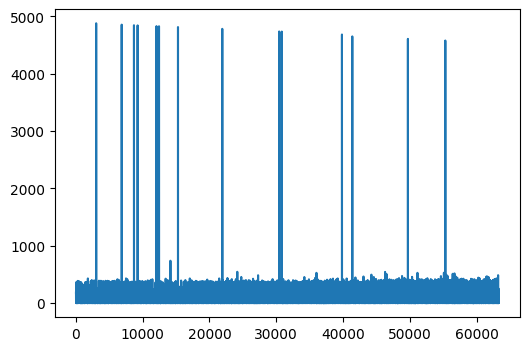

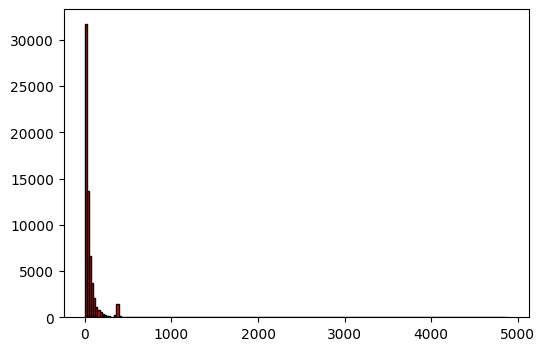

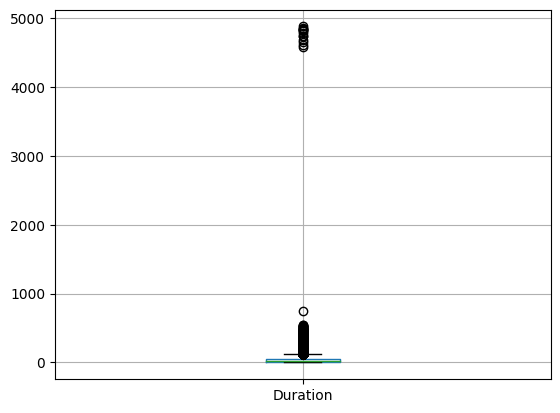

(None, None, None)

In [8]:
plot_feature(df, "Duration"), hist_feature(df, "Duration", 200), boxplot_feature(df, "Duration")

##### График для Age 

Тоже выбросы

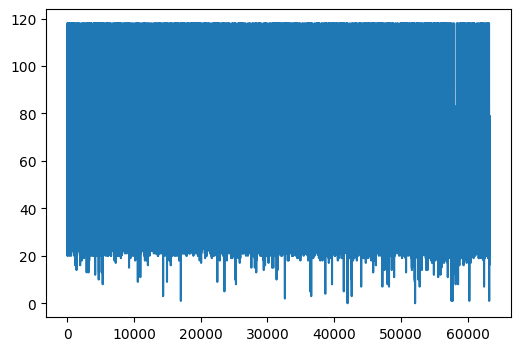

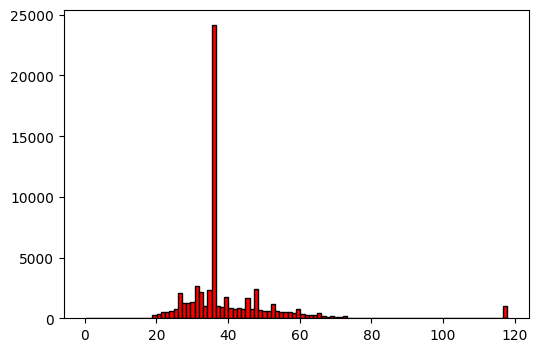

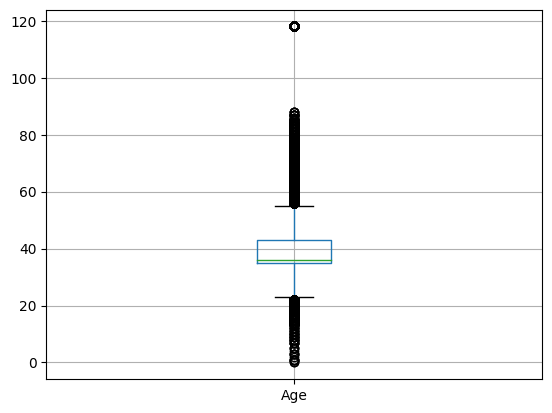

(None, None, None)

In [9]:
plot_feature(df, "Age"), hist_feature(df, "Age", 100), boxplot_feature(df, "Age")

##### График для Net Sales

Вроде ситуация получше, да и при попытке убирать выбросы в этом столбце результат ухудшался

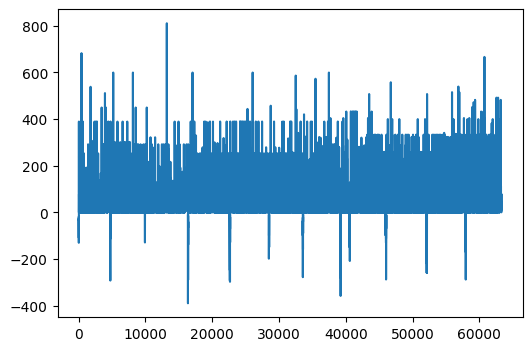

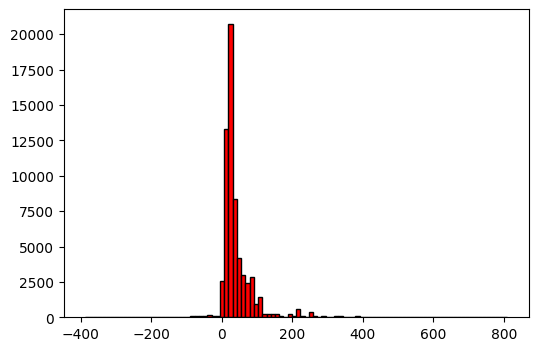

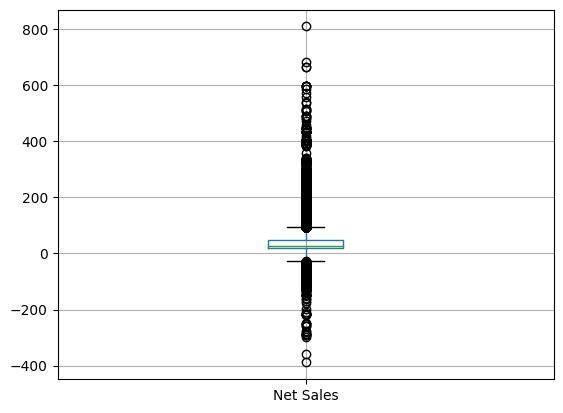

(None, None, None)

In [10]:
plot_feature(df, "Net Sales"), hist_feature(df, "Net Sales", 100), boxplot_feature(df, "Net Sales")

##### График для Comission

Как будто бы все плохо, но тут тоже ситация такая, что при удалении значений, не поадающих в межквартильный размах, модель ухудшится

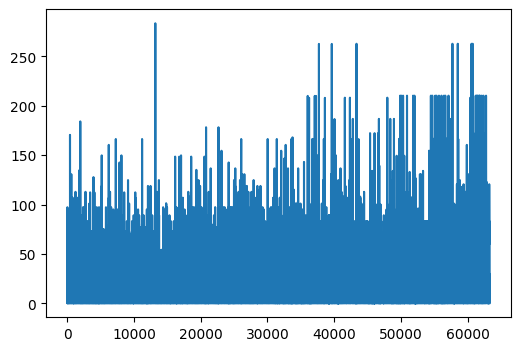

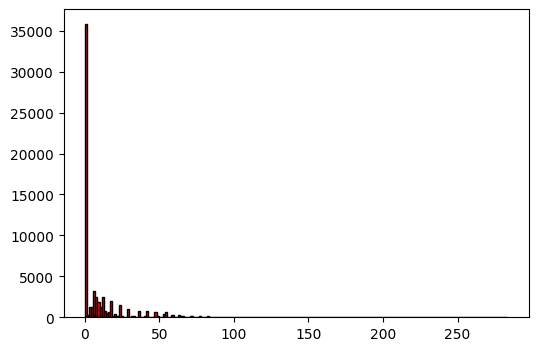

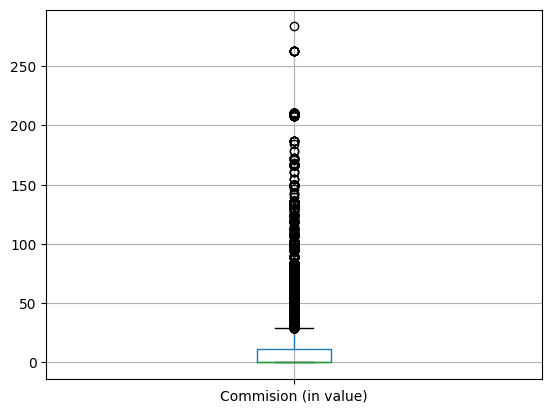

(None, None, None)

In [11]:
plot_feature(df, "Commision (in value)"), hist_feature(df, "Commision (in value)", 200), boxplot_feature(df, "Commision (in value)")

#### Как убирать выбросы?

Исходя из графиков, больше всего требуют чистки Duration и Age. Однако вместо простого удаления я хочу данные заменить на другие (жалко терять несколько тысяч строк датасета). Заменять на какое-то конкретное число - не вариант, образуется тогда большой класс. Здесь можно применить интерполяцию. Тогда те значения, которые выпадают из межквартильного размаха, будем интерполировать, а "нормальные" значения оставим в покое 

In [12]:
def data_beetween_q1_and_q3(df, column):
    q1, q3 = df[column].quantile(0.25), df[column].quantile(0.75)
    iqr = q3 - q1
    threshold = 1.5
    mask = (df[column] < q1 - iqr * threshold) | (df[column] > q3 + iqr * threshold) | df[column].isna()
    outliers = df[mask]
    df2 = df.copy()
    df2.loc[outliers.index, column] = np.nan
    df2[column] = df2[column].interpolate(limit_direction="both")
    return df2

In [13]:
df = df[df["Duration"] > 0]  # duration не может быть меньше 0
df = data_beetween_q1_and_q3(df, "Duration")  # убрать выбросы в Duration
df = data_beetween_q1_and_q3(df, "Age")  # убрать выбросы в Age

#### Графики для исправленных фичей

##### График для Duration

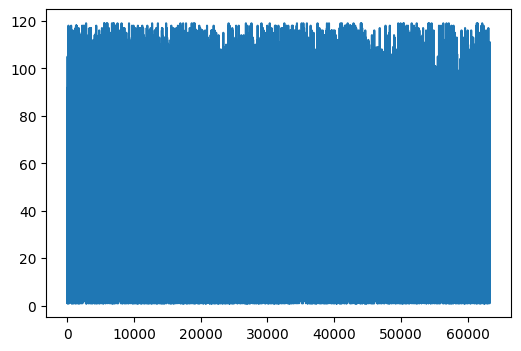

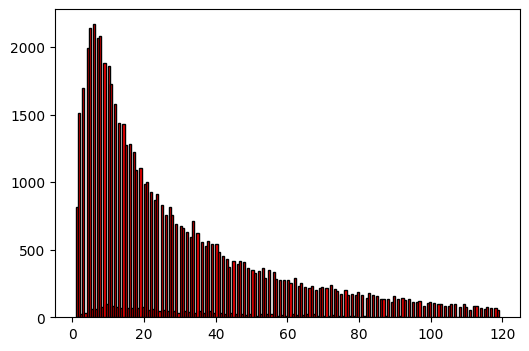

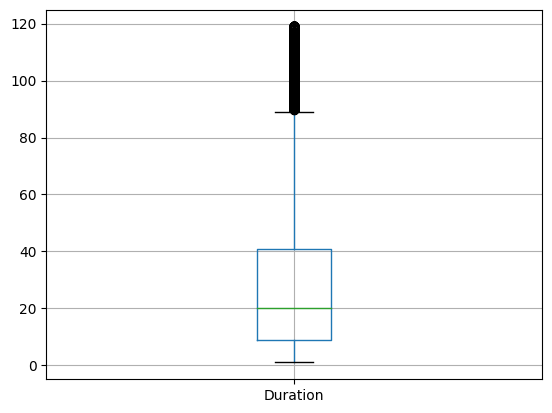

(None, None, None)

In [14]:
plot_feature(df, "Duration"), hist_feature(df, "Duration", 200), boxplot_feature(df, "Duration")

##### График для Age

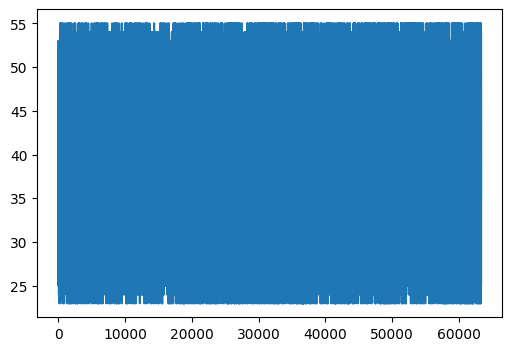

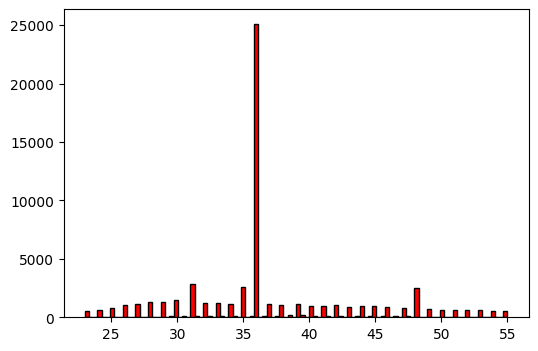

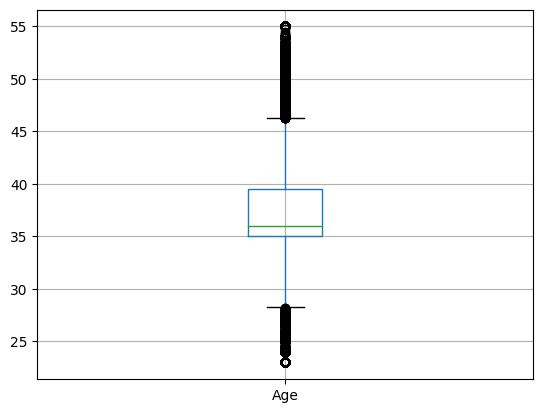

(None, None, None)

In [15]:
plot_feature(df, "Age"), hist_feature(df, "Age", 100), boxplot_feature(df, "Age")

### Делать ли downsampling?

Как можно заметить из всех графиков ниже (плюс графики распределения для числовых фичей выше), в датасете есть огромные классы по какому-либо признаку. Например, большой класс по возрасту в 36 лет или большой класс по континентку Asia. После некоторых тестов я решил не пытаться их уменьшать (я пробовал как sample из рандомных строк класса оставлять, так и брать центральные точки кластеров, полученные через метод K средних), поскольку тогда, во-первых, данных становится слишком мало, и из-за этого точность модели уменьшается, а во-вторых, при попытке уменьшать некоторые из классов матрица модели становится вырожденной.

#### Графики распределения величин с большими классами

##### График для Agency

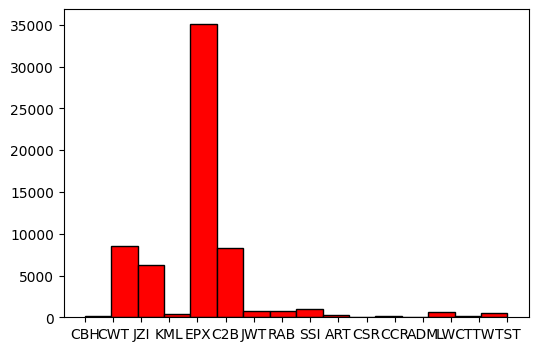

In [16]:
hist_feature(df, "Agency", df["Agency"].nunique())

##### График для Distribution Channel

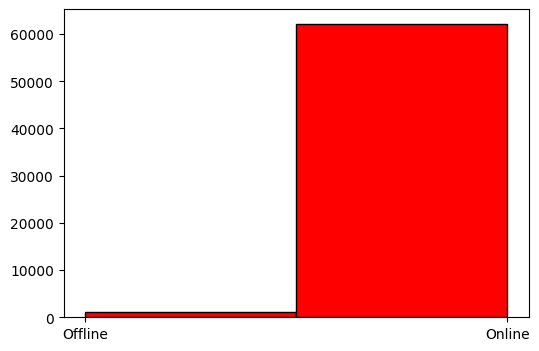

In [17]:
hist_feature(df, "Distribution Channel", df["Distribution Channel"].nunique())

##### График для Continent

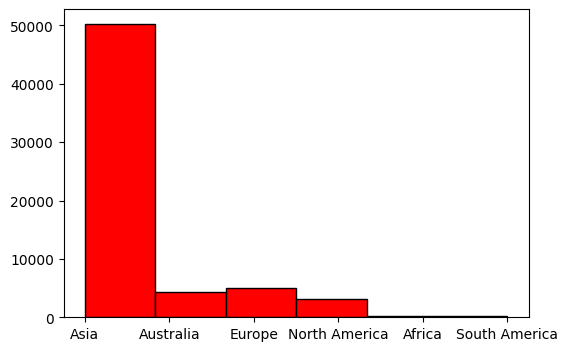

In [18]:
hist_feature(df[~df["Continent"].isna()], "Continent", df["Continent"].nunique())

### Заполнение пропусков

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63260 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63260 non-null  object 
 1   Agency Type           63260 non-null  object 
 2   Distribution Channel  63260 non-null  object 
 3   Product Name          63260 non-null  object 
 4   Claim                 63260 non-null  int32  
 5   Duration              63260 non-null  float64
 6   Net Sales             63260 non-null  float64
 7   Commision (in value)  63260 non-null  float64
 8   Gender                18180 non-null  object 
 9   Age                   63260 non-null  float64
 10  Continent             63255 non-null  object 
dtypes: float64(4), int32(1), object(6)
memory usage: 7.6+ MB


Значительные пропуски у нас в столбце Gender. Просто удалять все строки с пропущенным полом глупо - теряем две трети датасета. Тогда есть две идеи:

1) Удалить столбец. Сработает, однако, как было установлено на опыте, линейная регрессия из sklearn тогда выдает очень плохой результат (MSE=0.98). Аналитическое решение, написанное мной лично, в этом случае дает более адекватный ответ (MSE=0.03), однако не хочется, чтобы разница в применении двух методов для получения весов была такая большая

2. Восстановить данные. Вариант восстановления через заполнение конкретным числом (средним, нулем, медианой) отметаем, потому что тогда в датасете будет огромный класс с одним полом (это касается не только пола, о чем будет речь дальше), что может негативно сказаться на модели. Восстановление через интерполяцию именно для пола тоже не вариант, так как в датасете пропуски идут подряд; интерполяция просто ничего не изменит. Мой вариант - RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [21]:
# RandomForest может работать только с числами, поэтому сразу выполним 
# one hot encoding, который потом еще будем использовать впоследстви

X = pd.get_dummies(df.drop(columns=["Gender"]), dtype="int")
y_gender = df["Gender"]
y_gender_isna = y_gender[y_gender.isna()]
y_gender_is_not_na = y_gender[~y_gender.isna()]
X_gender_isna = X.loc[y_gender_isna.index]
X_gender_is_not_na = X.loc[y_gender_is_not_na.index]

In [22]:
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(
    X_gender_is_not_na, y_gender_is_not_na, test_size=0.9, random_state=47
)

forest = RandomForestClassifier()
forest.fit(X_gender_train, y_gender_train)
print("Accuracy для train:", accuracy_score(y_gender_train, forest.predict(X_gender_train)))
print("Accuracy для test:", accuracy_score(y_gender_test, forest.predict(X_gender_test)))
# Не очень, но лучше, чем ничего

Accuracy для train: 0.9911991199119912
Accuracy для test: 0.5635619117467302


In [23]:
# Получим столбец с восстановленными данными
y_gender.loc[y_gender_isna.index] = forest.predict(X_gender_isna)
# Преобразуем в one hot и положим на свое законное место в датасете
one_hot_gender = pd.get_dummies(y_gender, dtype=int, prefix="Gender")
X = pd.concat([X, one_hot_gender], axis=1)

C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_1480\2604162592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_gender.loc[y_gender_isna.index] = forest.predict(X_gender_isna)


## Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [26]:
y = X["Claim"]
X = X.drop(columns=["Claim"])
# Выполним MinMax scale
X_scaled = MinMaxScaler().fit(X).transform(X)
# Добавим столбец из единиц, чтобы получить свободный член
X_matrix = np.hstack([np.ones(len(X)).reshape(-1, 1), X_scaled])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, train_size=0.8, random_state=47)

#### Аналитическое решение

In [28]:
def solve_linear_regression(X, y, X2, y2, l2=None):
    X_t = X.transpose()
    if l2 is None:
        w = np.linalg.inv(X_t @ X) @ X_t @ y
    else:
        n, _ = X_t.shape
        w = np.linalg.inv(X_t @ X + l2 * np.ones(n)) @ X_t @ y
    pred = X2 @ w
    rnd = np.clip(np.round(pred), 0, 1)
    return w, rnd, mean_squared_error(y2, rnd)

##### Без регуляризации

In [29]:
w, ans, mse = solve_linear_regression(X_train, y_train, X_test, y_test)
print("MSE без регуляризации:", mse)
print(w)

MSE без регуляризации: 0.047186215618084094
[-1.63749461e+14 -8.93548374e-01  1.99064171e+01 -8.87623599e+00
 -1.74610258e+00  1.33747456e+14  2.78051579e+14  2.23135846e+14
  1.33747456e+14  1.33747456e+14  1.33747456e+14 -4.30137429e+12
 -5.91768871e+13  2.78051579e+14  2.78051579e+14  1.33747456e+14
 -2.78819087e+15  2.78051579e+14 -7.62271553e+14  2.46673008e+15
  4.18071745e+16  3.20537654e+13  1.76357888e+14 -5.00548566e+13
 -5.00548566e+13  9.66233170e+13  9.66233170e+13 -9.63010264e+13
 -4.13852932e+13 -4.13852932e+13  2.82563730e+15  2.82563730e+15
  2.82563730e+15 -9.63010264e+13 -4.13852932e+13  9.66233170e+13
 -4.17697281e+16 -9.63010264e+13 -4.13852932e+13 -4.17697281e+16
 -9.63010264e+13  4.17478042e+13 -4.13852932e+13  2.82563730e+15
  2.82563730e+15  2.82563730e+15 -4.17697281e+16  9.44022105e+14
 -2.42928365e+15 -2.42928365e+15 -9.63010264e+13  7.98081766e+00
  8.09254705e+00  7.98366069e+00  7.99378234e+00  7.93123696e+00
  7.91856489e+00 -1.54206543e+01 -1.56539230e+

##### С регуляризацией

In [30]:
w, ans, mse = solve_linear_regression(X_train, y_train, X_test, y_test, l2=10)
print("MSE с регуляризацией:", mse)
print(w)

MSE с регуляризацией: 0.3105437875434714
[-2.10432957e+13 -1.07328436e+00  3.97695428e+01 -6.12679891e-01
 -1.29183896e+00 -5.15419852e+13  6.26297872e+12  8.66173183e+13
 -5.15419852e+13 -5.15419852e+13 -5.15419852e+13 -8.68749334e+13
 -4.30296415e+13  6.26297872e+12  6.26297872e+12 -5.15419852e+13
  6.43001879e+13  6.26297872e+12  1.05811026e+14  1.13954645e+14
 -6.73917988e+14  2.70269448e+13  8.48319087e+13 -2.26598450e+13
 -2.26598450e+13  1.90087357e+12  1.90087357e+12  1.04132172e+13
 -6.99411224e+13 -6.99411224e+13 -1.05428956e+14 -1.05428956e+14
 -1.05428956e+14  1.04132172e+13 -6.99411224e+13  1.90087357e+12
  6.32789220e+14  1.04132172e+13 -6.99411224e+13  6.32789220e+14
  1.04132172e+13  4.57461655e+13 -6.99411224e+13 -1.05428956e+14
 -1.05428956e+14 -1.05428956e+14  6.32789220e+14 -8.91348299e+13
 -1.55083413e+14 -1.55083413e+14  1.04132172e+13  8.14038166e+00
  8.10668245e+00  8.10626884e+00  8.10683677e+00  8.11681772e+00
  8.12161399e+00  1.10549927e-01  1.09546661e-01]

#### Модель Linearregression из sklearn

##### Без регуляризации

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
model = LinearRegression().fit(X_train, y_train)
w = model.coef_
w[0] = model.intercept_
pred = np.clip(np.round(model.predict(X_test)), 0, 1)
print("MSE у модели из sklearn:", mean_squared_error(y_test, pred))
print(w)

MSE у модели из sklearn: 0.015728738539361367
[-5.77548093e+11  8.82018088e-03  1.78043768e-01  2.49663242e-02
 -7.07965230e-03 -1.08641790e+11 -6.70084989e+11 -3.60056401e+11
 -1.08641790e+11 -1.08641790e+11 -1.08641790e+11  1.65237669e+11
  5.64805710e+11 -6.70084989e+11 -6.70084989e+11 -1.08641790e+11
  1.64628591e+12 -6.70084989e+11  1.16088907e+12  6.43927761e+11
  3.77220926e+11  2.71209430e+11 -2.90233769e+11  7.17870688e+09
  7.17870688e+09 -5.32218708e+10 -5.32218708e+10  6.20225629e+11
  3.10197041e+11  3.10197041e+11 -1.13470207e+12 -1.13470207e+12
 -1.13470207e+12  6.20225629e+11  3.10197041e+11 -5.32218708e+10
  1.34362914e+11  6.20225629e+11  3.10197041e+11  1.34362914e+11
  6.20225629e+11  3.46346170e+11  3.10197041e+11 -1.13470207e+12
 -1.13470207e+12 -1.13470207e+12  1.34362914e+11 -1.21074843e+12
 -1.32343922e+11 -1.32343922e+11  6.20225629e+11  2.13623047e-02
  1.89208984e-02  1.84326172e-02  1.90429688e-02  1.90429688e-02
  1.85546875e-02  3.49019212e+11  3.49019212

##### С регуляризацией

In [33]:
from sklearn.linear_model import Ridge

In [34]:
model = Ridge(alpha=1).fit(X_train, y_train)
w = model.coef_
w[0] = model.intercept_
pred = np.clip(np.round(model.predict(X_test)), 0, 1)
print("MSE у модели из sklearn:", mean_squared_error(y_test, pred))
print(w)

MSE у модели из sklearn: 0.015728738539361367
[-3.86329355e-02  8.55565208e-03  1.80433593e-01  1.36332719e-02
 -7.21577580e-03  1.60322647e-02  5.90050459e-03  2.90324625e-02
 -3.04555272e-02 -3.68177154e-02 -3.10471517e-02  8.52498083e-03
  1.15274895e-02 -7.56038675e-03 -4.48829939e-03  3.91266056e-02
  3.63567323e-02 -2.85659245e-03 -4.39389903e-03 -2.25984766e-02
 -6.28299133e-03  1.56337895e-02 -1.56337895e-02  2.64786848e-02
 -2.64786848e-02  2.39791367e-03  7.24028008e-03 -2.18206234e-02
 -4.50965825e-03  3.27798868e-02  3.75084688e-02 -5.29358444e-02
  8.49036547e-06 -1.08949434e-02  1.14728091e-03  1.88929576e-03
 -3.87190431e-02  1.38870454e-03 -6.58705636e-03 -1.10095922e-02
 -6.64341242e-03  8.52498083e-03  6.20200940e-03  2.48699586e-02
  3.93003143e-02 -1.23946555e-02  4.34456440e-02 -4.39389903e-03
 -1.45656709e-02 -8.03280574e-03 -1.41960234e-02  9.51831542e-03
  7.52829249e-03  6.95144432e-03  7.88300733e-03  7.22485762e-03
  5.97948765e-03  7.82754610e-04 -7.82754610

### Вывод (1 балла)

Подробные объяснения даны были выше, здесь резюмирую:
1) Выбросы в данных определяются через межквартильное расстояние, в датасете выбросы заменяются на значения, полученные через интерполяцию. Выбросы убраны для фич Duration и Age
2) Для уменьшения количества уникальных значений категориальных фич страна направления была заменена на континент
3) Пропуски в данных (столбец Gender) восстановлены с помощью классификации RandomForest
4) Downsampling не применен, поскольку на тестах результата не дал

Построенная модель имеет достаточно низкую MSE (около 0.03, если брать среднее по нескольким подсчетам, так как из-за RandomForest это не постоянная величина), что достаточно хорошо, к тому же, это почти совпадает с MSE у модели из sklearn. Однако модель имеет достаточно большие веса. Модель из sklearn тоже, конечно, но при применении регуляризации модель sklearn получает маленькие веса, а моя - не намного меньше предыдущих. Для уменьшения весов, думаю, стоит еще как-то по-хитрому группировать значения категориальных фичей. 

Но в целом модель справляется со своей задачей хорошо, о чем свидетельсвуют метрики оценки. В практических целях может быть применена